In [1]:
import unittest

import cupy as cp
import xarray as xr

import src.geocat.comp.meteorology as geo

import numpy as np
import time
import pandas as pd
import cupy as cp
from test.test_meteorology import Test_relhum

## Testing Numpy input and CPU

In [2]:
xp = np
p_def = xp.random.uniform(low=2000,high=100800,size=10**3)
t_def = xp.random.uniform(low=194.65,high=302.45,size=10**3)
q_def = xp.random.uniform(low=0,high=0.02038,size=10**3)
rh_gt_2 = geo.relhum(t_def, q_def, p_def, use_gpu = False)

## Testing Numpy input and GPU

In [3]:
xp = np
p_def = xp.random.uniform(low=2000,high=100800,size=10**3)
t_def = xp.random.uniform(low=194.65,high=302.45,size=10**3)
q_def = xp.random.uniform(low=0,high=0.02038,size=10**3)
rh_gt_2 = geo.relhum(t_def, q_def, p_def, use_gpu = True)

## Testing Xarray input with CPU

In [4]:
p = xr.DataArray(p_def).chunk(10)
t = xr.DataArray(t_def).chunk(10)
q = xr.DataArray(q_def).chunk(10)
a = geo.relhum(t, q, p, use_gpu = False)

## Testing Xarray input with GPU

In [5]:
p = xr.DataArray(p_def).chunk(10)
t = xr.DataArray(t_def).chunk(10)
q = xr.DataArray(q_def).chunk(10)
a = geo.relhum(t, q, p, use_gpu = True)

## Unittests with CPU!

In [6]:
test = Test_relhum()

test.setUpClass()
test.test_float_input(use_gpu = False)
test.test_list_input(use_gpu = False)
test.test_numpy_input(use_gpu = False)
test.test_dims_error(use_gpu = False)
test.test_xarray_type_error(use_gpu = False)
test.test_dask_compute(use_gpu = False)
test.test_dask_lazy(use_gpu = False)

2022-06-23 12:01:59,223 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/u/home/hkashgar/geocat-comp/dask-worker-space/worker-11ni1044', purging
2022-06-23 12:01:59,223 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/u/home/hkashgar/geocat-comp/dask-worker-space/worker-3lesz_ee', purging


## Unittests with GPU

In [7]:
test = Test_relhum()

test.setUpClass()
test.test_float_input(use_gpu = True)
test.test_list_input(use_gpu = True)
test.test_numpy_input(use_gpu = True)
test.test_dims_error(use_gpu = True)
test.test_xarray_type_error(use_gpu = True)
test.test_dask_compute(use_gpu = True)
test.test_dask_lazy(use_gpu = True)

/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34960 instead
  warnings.warn(


## Benchmark Results for different Array Sizes

In [10]:
def test_numpy_input(use_gpu):
    p = np.asarray(p_def)
    t = np.asarray(t_def)
    q = np.asarray(q_def)
    
    assert xp.allclose(geo.relhum(t, q, p,use_gpu), rh_gt_2, atol=0.1)

In [19]:
#Test_relhum main body
Routine = "Relhum"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,8):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    #for numpy and cupy both
    for xp in [np,cp]:
        #calculation will be repeated 10 time to get the less biased performance results
        repeat = np.zeros([10])
        repsize = 10
        for rep in range(0,repsize):
            #create different sizes of arrays
            p_def = np.random.uniform(low=2000,high=100800,size=10**i)
            t_def = np.random.uniform(low=194.65,high=302.45,size=10**i)
            q_def = np.random.uniform(low=0,high=0.02038,size=10**i)
            if(xp == cp):
                geo.relhum(t_def, q_def, p_def,True)
                cp.cuda.runtime.deviceSynchronize()
                time1 = time.time()
                geo.relhum(t_def, q_def, p_def,True)
                cp.cuda.runtime.deviceSynchronize()
                time2 = time.time()
                repeat[rep] = time2-time1
            else:
                time1 = time.time()
                geo.relhum(t_def, q_def,p_def,False)
                time2 = time.time()
                repeat[rep] = time2-time1
        #save times
        data = {'Routine': np.repeat(Routine, repsize),
                'Approach': np.repeat(xp.__name__ , repsize),
                'ArraySize': np.repeat(ArraySize , repsize),
                'iteration' : np.arange(1,repsize+1),
                'Runtime(s)': repeat}
        new = pd.DataFrame(data)
        allData = pd.concat([allData,new], ignore_index=True)
        print(xp.__name__,np.mean(repeat), "seconds")

Relhum
Array size:  10
numpy 6.773471832275391e-05 seconds
cupy 0.0008260965347290039 seconds
Array size:  100
numpy 7.314682006835938e-05 seconds
cupy 0.0006152153015136719 seconds
Array size:  1000
numpy 7.710456848144531e-05 seconds
cupy 0.0005006790161132812 seconds
Array size:  10000
numpy 0.00018575191497802735 seconds
cupy 0.0005466938018798828 seconds
Array size:  100000
numpy 0.002039384841918945 seconds
cupy 0.0009038209915161133 seconds
Array size:  1000000
numpy 0.025208568572998045 seconds
cupy 0.006637716293334961 seconds
Array size:  10000000
numpy 0.4949803829193115 seconds
cupy 0.05858581066131592 seconds


## Plotting

In [24]:
import matplotlib.pyplot as plt
import numpy as np

arraysizes = np.unique(allData['ArraySize'])
sd_numpy = np.zeros(len(arraysizes))
sd_cupy = np.zeros(len(arraysizes))
y_numpy = np.zeros(len(arraysizes))
y_cupy = np.zeros(len(arraysizes))

for i in range(0,len(arraysizes)):
    cupydata = allData.loc[(allData['ArraySize'] == arraysizes[i]) & (allData['Approach'] == 'cupy')]
    numpydata = allData.loc[(allData['ArraySize'] == arraysizes[i]) & (allData['Approach'] == 'numpy')]
    y_cupy[i] = np.mean(cupydata['Runtime(s)'])
    y_numpy[i] = np.mean(numpydata['Runtime(s)'])
    sd_cupy[i] = np.std(cupydata['Runtime(s)'])
    sd_numpy[i] = np.std(numpydata['Runtime(s)'])

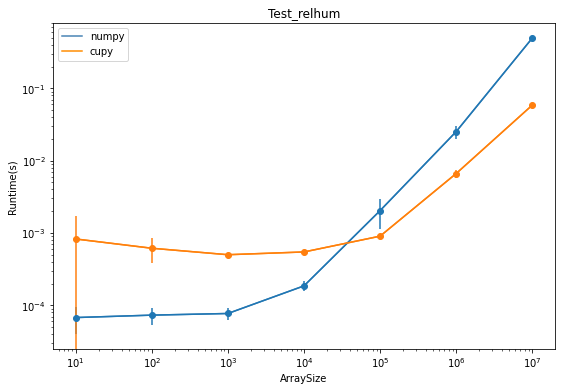

In [25]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.errorbar(arraysizes, y_numpy, yerr=sd_numpy, fmt='-o')
ax.errorbar(arraysizes, y_cupy, yerr=sd_cupy, fmt='-o')
ax.plot(arraysizes, y_numpy, label='numpy',color="steelblue")
ax.plot(arraysizes, y_cupy, label='cupy',color="darkorange")  # Plot more data on the axes...
ax.legend();  # Add a legend.
ax.set_xlabel('ArraySize')  # Add an x-label to the axes.
ax.set_ylabel('Runtime(s)')  # Add a y-label to the axes.
ax.set_title(("Test_relhum"))
ax.set_xscale('log')
ax.set_yscale('log')
#plt.savefig("Test_relhum.jpg",dpi=fig.dpi)